# Bias Intepretability

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# AIF360 as used in Bia_mitigation notebook
import numpy as np
import matplotlib.pyplot as plt

from aif360.datasets import AdultDataset 
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow.compat.v1 as tf
import tensorflow

# LIME: local interpretable model-agnostic explanations
from lime.lime_tabular import LimeTabularExplainer
from lime import submodular_pick

# iNNvestigate: iNNvestigate Neural Networks using Layer-wise relevance propagation
import innvestigate
import innvestigate.utils as iutils
import keras

## Adult Dataset

In [9]:
# protected features
protected = 'sex'
# privileged class 
privileged_classes = [['Male']]
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# load the dataset 
ad = AdultDataset(protected_attribute_names=[protected],
    privileged_classes=privileged_classes, categorical_features=[],
    features_to_keep=features_to_keep)

In [10]:
from collections import OrderedDict, defaultdict
from aif360.metrics import ClassificationMetric
#fucntion provided by aif360 
# helper functions for the task 
def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    # ClassificationMetric is a class that helps you compute all the relavent metrics
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Demographic Parity"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    # display the metrics if disp == True
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

def plot(metric_arrs, class_thresh_arr,best_ind, name_set):
    fig, ax = plt.subplots(2,2,figsize=(24,18))

    # plot of Balanced accuracy versus threshold
    ax[0,0].plot(class_thresh_arr, metric_arrs["Balanced accuracy"], color='b')
    ax[0,0].set_title(name_set, fontsize=12, fontweight='bold')
    ax[0,0].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
    ax[0,0].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
    ax[0,0].xaxis.set_tick_params(labelsize=12)
    ax[0,0].yaxis.set_tick_params(labelsize=12)
    ax[0,0].legend(["Balanced Accuracy"], fontsize=12)

    # plot of Equalized odds differnce versus threshold
    ax2 = ax[0,0].twinx()
    ax2.plot(class_thresh_arr, metric_arrs["Average odds difference"], color='r')
    ax2.set_ylabel('Equalized odds differnce', color='r', fontsize=12, fontweight='bold')
    ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=12)
    ax2.grid(True)
    ax2.legend(["Equalized odds"], fontsize=12, loc="lower left")

    # plot of Balanced accuracy versus threshold
    ax[0,1].plot(class_thresh_arr, metric_arrs["Balanced accuracy"], color='b')
    ax[0,1].set_title(name_set, fontsize=12, fontweight='bold')
    ax[0,1].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
    ax[0,1].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
    ax[0,1].xaxis.set_tick_params(labelsize=12)
    ax[0,1].yaxis.set_tick_params(labelsize=12)
    ax[0,1].legend(["Balanced Accuracy"], fontsize=12)

    # plot of Disparate impact versus threshold
    ax2 = ax[0,1].twinx()
    ax2.plot(class_thresh_arr, metric_arrs["Disparate impact"], color='r')
    ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
    ax2.set_ylabel('Disparate impact', color='r', fontsize=12, fontweight='bold')
    ax2.yaxis.set_tick_params(labelsize=12)
    ax2.grid(True)
    ax2.legend(["Disparate impact"], fontsize=12, loc="lower left")

    # plot of Balanced accuracy versus threshold
    ax[1,0].plot(class_thresh_arr, metric_arrs["Balanced accuracy"], color='b')
    ax[1,0].set_title(name_set, fontsize=12, fontweight='bold')
    ax[1,0].set_xlabel('Classification Thresholds', fontsize=12, fontweight='bold')
    ax[1,0].set_ylabel('Balanced Accuracy', color='b', fontsize=12, fontweight='bold')
    ax[1,0].xaxis.set_tick_params(labelsize=12)
    ax[1,0].yaxis.set_tick_params(labelsize=12)
    ax[1,0].legend(["Balanced Accuracy"], fontsize=12)

    # plot of Equalized opportunity differnce versus threshold
    ax2 = ax[1,0].twinx()
    ax2.plot(class_thresh_arr, metric_arrs["Equal opportunity difference"], color='r')
    ax2.axvline(np.array(class_thresh_arr)[best_ind], 
            color='k', linestyle=':')
    ax2.set_ylabel('Equalized opportunity differnce', color='r', fontsize=12, fontweight='bold')
    ax2.yaxis.set_tick_params(labelsize=12)
    ax2.grid(True)
    ax2.legend(["Equalized opportunity differnce"], fontsize=12, loc="lower left")
    
    fig.delaxes(ax[1][1])

def classifier(classifier, train, valid, test, unprivileged_groups,privileged_groups):
    """
    Trains the provided classifier on the training set. Uses the validation set to select the best threshold and evaulates
    it on the test set
    """
    
      
    # scalling operation 
    scale = StandardScaler()
    x_train = scale.fit_transform(train.features)
    y_train = train.labels.ravel()
    
    # train the model
    classifier.fit(x_train, y_train)
    
    # find the location of the favorable outcome
    fav_idx = np.where(classifier.classes_ == train.favorable_label)[0][0]      
    
    # prep the data for validation
    valid_pred = valid.copy(deepcopy=True)
    X_valid = scale.fit_transform(valid_pred.features)
    y_valid = valid_pred.labels
    # use the trained model to get the probabilities associated with the favorable outcome
    valid_pred.scores = classifier.predict_proba(X_valid)[:,fav_idx].reshape(-1,1)

    # prep the data for test
    test_pred = test.copy(deepcopy=True)
    X_test = scale.fit_transform(test_pred.features)
    y_test = test_pred.labels
    # use the trained model to get the probabilities associated with the favorable outcome
    test_pred.scores = classifier.predict_proba(X_test)[:,fav_idx].reshape(-1,1)


    num_thresh = 100
    ba_arr = np.zeros(num_thresh)
    # differnt threshold values
    class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

    metric_arrs = defaultdict(list)
    
    # find the best threshold based on balanced accuracy 
    for idx, class_thresh in enumerate(class_thresh_arr):
        # update the labels if the scores are greater than the threshold
        fav_inds = valid_pred.scores > class_thresh
        valid_pred.labels[fav_inds] = valid_pred.favorable_label
        valid_pred.labels[~fav_inds] = valid_pred.unfavorable_label

        
        metric_valid_bef = compute_metrics(valid, valid_pred, 
                                           unprivileged_groups, privileged_groups, disp=False)
        
        
        metric_arrs['Balanced accuracy'].append(metric_valid_bef["Balanced accuracy"])
        metric_arrs['Average odds difference'].append(metric_valid_bef["Average odds difference"])
        metric_arrs['Disparate impact'].append(metric_valid_bef["Disparate impact"])
        metric_arrs['Equal opportunity difference'].append(metric_valid_bef["Equal opportunity difference"])
        
        ba_arr[idx] = metric_valid_bef["Balanced accuracy"]
 
    best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
    best_class_thresh = class_thresh_arr[best_ind]
    print("Optimal classification threshold based on validation set = %.4f" % best_class_thresh)

    # testing the classifier
    # use the best threshold to update the labels for the test set
    fav_inds = test_pred.scores > best_class_thresh
    test_pred.labels[fav_inds] = test_pred.favorable_label
    test_pred.labels[~fav_inds] = test_pred.unfavorable_label
    print("Metrics for the test set:")
    metric_test_bef = compute_metrics(test, test_pred, 
                                       unprivileged_groups, privileged_groups, disp=True)
        
    plot(metric_arrs, class_thresh_arr,best_ind, 'Validation set')

In [14]:
# spllt the data into train , valid and test set 
ad_train, ad_test = ad.split([0.7], shuffle = False, seed=0)
ad_valid, ad_test = ad_test.split([0.5], shuffle=False, seed=0)

Optimal classification threshold based on validation set = 0.2278
Metrics for the test set:
Balanced accuracy = 0.7511
Demographic Parity = -0.3326
Disparate impact = 0.3118
Average odds difference = -0.2793
Equal opportunity difference = -0.3278
Theil index = 0.1119


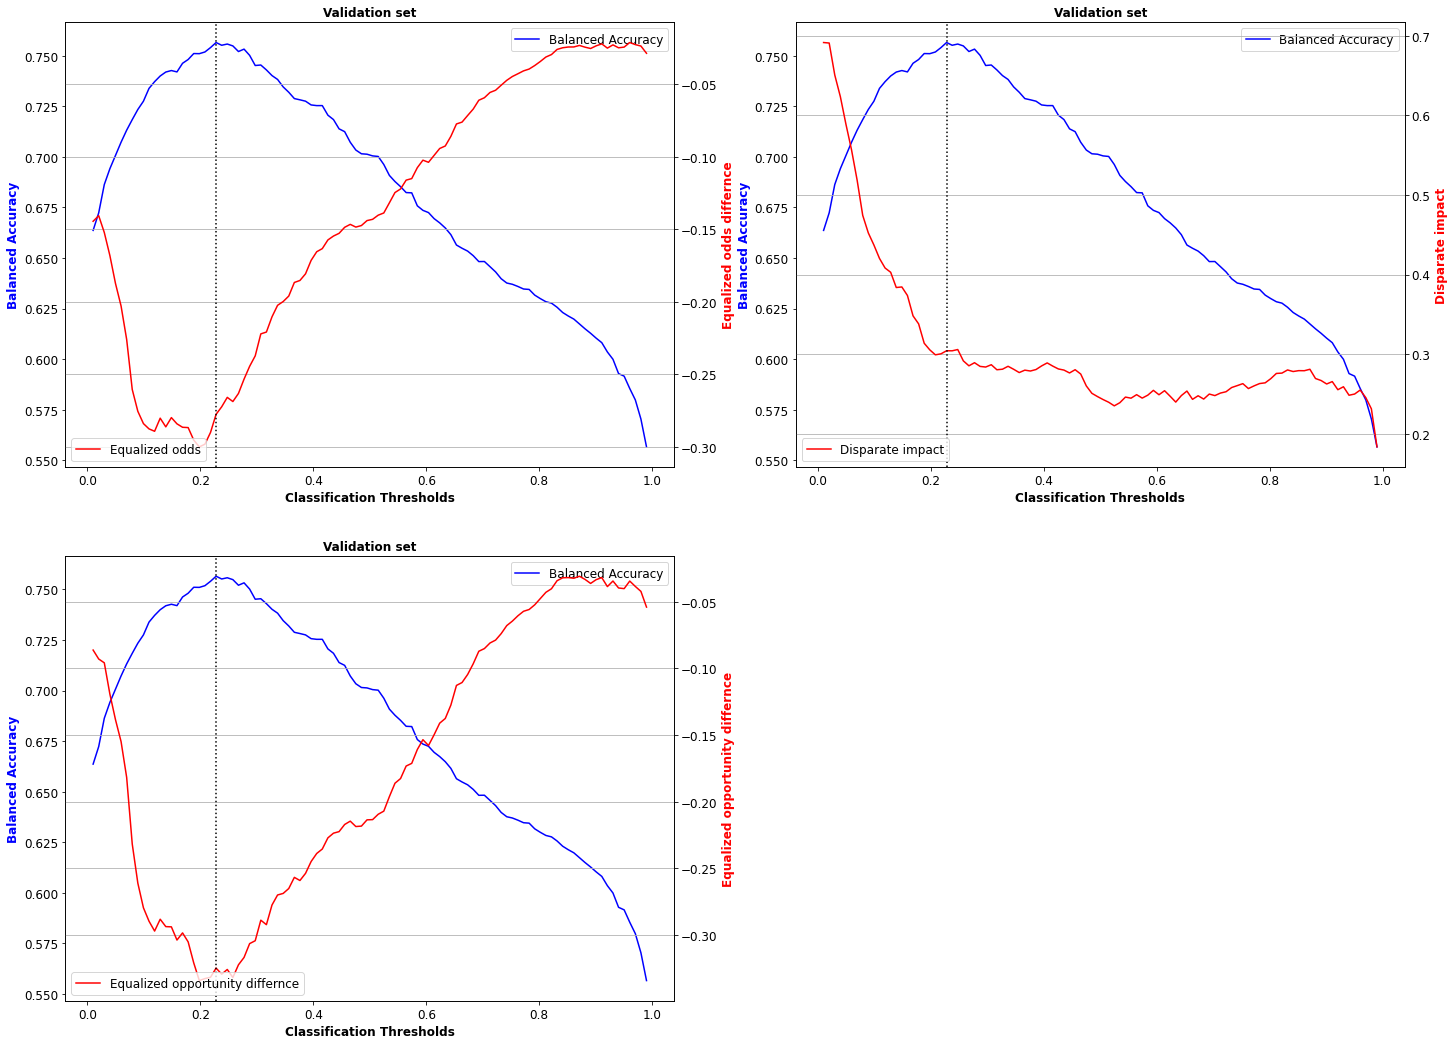

In [21]:
clf = RandomForestClassifier()
classifier(clf, ad_train, ad_valid, ad_test,unprivileged_groups,privileged_groups)

## Celeb A Dataset

In [17]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator

from scripts.celeb_dataset import CelebA

In [15]:
def build_model(num_features):
  base = MobileNetV2(input_shape=(224, 224, 3),
                     weights=None,
                     include_top=False,
                     pooling='avg')  # GlobalAveragePooling 2D
  
  # model top
  x = base.output
  x = tf.keras.layers.Dense(1536, activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  top = tf.keras.layers.Dense(num_features, activation='softmax')(x)
  
  return tf.keras.models.Model(inputs=base.input, outputs=top)

In [8]:
celeba = CelebA(main_folder='../data/celeb_a/', 
                drop_features=['Attractive',
                               'Pale_Skin',
                               'Blurry'])

In [9]:
celeba.attributes.sample(5)

,5_o_Clock_Shadow,Arched_Eyebrows,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Brown_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,image_id
image_id,,,,,,,,,,,,,,,,,,,,,
080267.jpg,0,1,0,0,0,1,0,1,0,0,...,1,0,1,1,0,1,1,0,1,080267.jpg
119898.jpg,0,0,1,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,119898.jpg
164935.jpg,1,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,1,164935.jpg
131910.jpg,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,1,131910.jpg
182800.jpg,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,182800.jpg


In [16]:
model = build_model(num_features=celeba.num_features)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [27]:
batch_size = 128
num_epochs = 12

# augumentations for training set:
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   rescale=1./255, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

# only rescaling the validation set
valid_datagen = ImageDataGenerator(rescale=1./255)


# get training and validation set:
train_split = celeba.split('training'  , drop_zero=False)
valid_split = celeba.split('validation', drop_zero=False)

# data generators:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='other'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='other'
)

Found 162770 validated image filenames.
Found 19867 validated image filenames.


In [24]:
model.compile(loss='cosine_proximity',
              optimizer='adadelta',
              metrics=['binary_accuracy'])

In [ ]:
save_path = '../models/'

model_path = f"{save_path}/weights-FC{celeba.num_features}-MobileNetV2" + "{val_binary_accuracy:.2f}.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    monitor='val_binary_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1)

# fitting:
history = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    max_queue_size=1,
    shuffle=True,
    callbacks=[checkpoint],
    verbose=1)

2022-01-10 17:02:30.587958: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-10 17:02:30.588263: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/12
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
